# **Activation_Maximization & Saliency**

## NOT DONE.

# GRADCAM

In [0]:
from google.colab import drive
drive.mount('/content/my-drive')
!ls /content/my-drive/'My Drive'/eva_stored_from_colab/

import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/my-drive; to attempt to forcibly remount, call drive.mount("/content/my-drive", force_remount=True).
drive_location			      eva_9_PRE_gradcam_model.hdf5
eva_6_assignment_improved_model.hdf5  tonystark.png
eva_9gradcam_model.hdf5


Let's start with a pretrained VGG model

In [0]:
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

(1, 224, 224, 3)


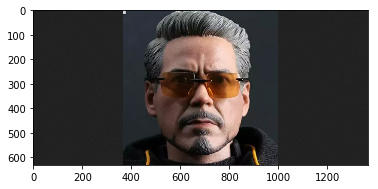

In [0]:
model = VGG16(weights="imagenet")
from skimage import io
tonystark = io.imread("/content/my-drive/My Drive/eva_stored_from_colab/tonystark.png")
plt.imshow(tonystark)
tonystark_3ch = cv2.cvtColor(tonystark, cv2.COLOR_BGRA2BGR )
tonystark_3ch = cv2.resize(tonystark_3ch, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tonystark_3ch)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [0]:
model.layers[-6].name

'block5_conv3'

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)
print(len(grads))
grads = grads[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

1
(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the results

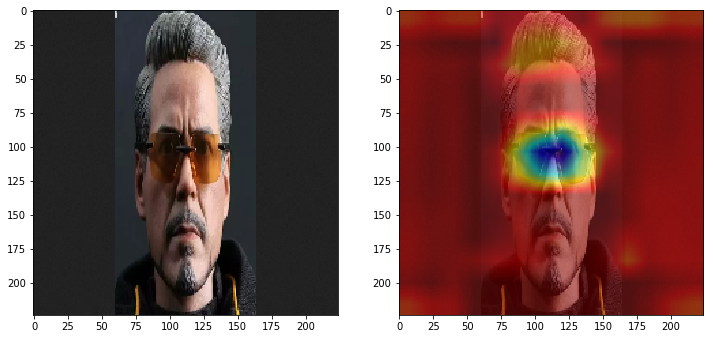

In [0]:
heatmap = cv2.resize(heatmap, (tonystark_3ch.shape[1], tonystark_3ch.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(tonystark_3ch, 0.5, heatmap, 0.5, 0)
#from google.colab.patches import cv2_imshow
#cv2_imshow( tonystark_3ch)
#cv2_imshow(superimposed_img)
fig, ax = plt.subplots(1, 2,figsize=(12, 6))
ax[0].imshow( tonystark_3ch)
ax[1].imshow(superimposed_img)